# Analysing The Impact of a New E-commerce Web Page on Conversion Rate (A/B Testing)

***

In this project we will run an A/B testing analysis by leveraging the Chi-Square test for independence and assess the impact of a new ecommerce web page on the users conversion rate compared to an old web page.

# Project Summary

***

## Context


An e-commerce company has developed a new web page in order to try and increase the number of users who "convert," meaning the number of users who decide to pay for the company's product.  

The users were randomly divided into two groups: the treatment group have access to only the new web page and the control group have access to only the old web page.  

The company want understand if they should implement this new page, keep the old page, or perhaps run the experiment longer to make their decision.

## Actions

To perform our analysis, we first explored the data and made some cleanup. We observed there are 3,895 duplicated user_id, some of these users where exposed to both the new and old web pages and some users where in both treatment group and control group. This mismatch entries were about 1.32% of the entire dataset. For the purpose of our analysis we excluded the mismatched data to resolve the disparity.


To compare the conversion rate of the two groups, we used the Chi-Square test for independence. To run the test, we set the following hypothesis and alpha level:

* Null Hypothesis = There is no relationship between landing page type and conversion rate.
* Alternate Hypothesis = There is a relationship between landing page type and conversion rate.
* Alpha = 0.05

## Results & Conclusion

We performed the analysis and obtained the following results:

* users from the ***control*** group had a conversion rate of ***12.03%*** 
* users from the ***treatment*** group had a conversion rate of ***11.88%***  

We noticed the users of the old web page have a bit higher conversion rate than the users of the new web page.  We then performed the Chi-Squared test.

The results obtained from the Chi-Square test gave us a p-value of ***0.19*** which is greater than our alpha value of ***0.05*** and a chi-square statistic of ***1.71*** which is less than our critical value of ***3.84***.  
Hence we failed to reject the Null Hypothesis and concluded that there was no significant difference between the conversion rates of the old landing page and the new landing page.  

In conclusion, our analysis showed that it will not be a good idea for the company to change their old web page for the new one at the moment.  
We recommended that the company runs the experiment again to collect more data and make sure users from each group only access the web page their supposed to access. Doing that may help us obtain more insight.

***

## Loading Required Packages

In [1]:
# load the required python libraries
import pandas as pd
from scipy.stats import chi2_contingency, chi2

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style("whitegrid")

import warnings
warnings.filterwarnings('ignore')

## Data Description & Preparation

***

We will load the data collected by the company after the experiment and have a preview of the first 5 rows. This will give us a feel of how the data is stored. We will then describe the data to have an idea of the full structure.

In [2]:
# load the data & check the first 5 rows 
df = pd.read_csv('./campaign_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,11:48.6,control,old_page,0
1,804228,01:45.2,control,old_page,0
2,661590,55:06.2,treatment,new_page,0
3,853541,28:03.1,treatment,new_page,0
4,864975,52:26.2,control,old_page,1


In [3]:
# describe the entire dataset after excluding the timestamp
df1=df.drop('timestamp', axis=1)
summary_list = [df1.describe().T]+[df1.groupby([c])[df1.columns[0]].count() for c in df1.columns if df[c].dtype == 'object']

for i in summary_list:
    print(i)
    print()

              count           mean           std       min        25%  \
user_id    294480.0  787973.538896  91210.917091  630000.0  709031.75   
converted  294480.0       0.119658      0.324562       0.0       0.00   

                50%        75%       max  
user_id    787932.5  866911.25  945999.0  
converted       0.0       0.00       1.0  

group
control      147202
treatment    147278
Name: user_id, dtype: int64

landing_page
new_page    147241
old_page    147239
Name: user_id, dtype: int64



In [4]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294480 entries, 0 to 294479
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   user_id       294480 non-null  int64 
 1   timestamp     294480 non-null  object
 2   group         294480 non-null  object
 3   landing_page  294480 non-null  object
 4   converted     294480 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


We can observed the data consist of 5 columns (user_id, timestamp, group, landing_page, converted) and 294480 entries. The ***group*** consist of 2 levels, ***control*** and ***treatment***. The ***control*** represent users who were not exposed to the new web page, and the ***treatment*** consist of users who were exposed to the new web page. The ***landing_page*** also consist of 2 levels, ***old_page*** and ***new_page***. The ***converted*** column consist of 0 and 1 where 1 indicate the user bought an item and 0 indicate the user didn't purchase an item.

## Data Cleaning

Let's check if there is any duplicated entries

In [5]:
df.duplicated().sum()

0

In [6]:
# checking for duplicated user id
df.user_id.duplicated().sum()

3895

In [7]:
# percentage of duplicated data
df.user_id.duplicated().sum()/len(df)*100

1.3226704699809835

In [8]:
duplicated_ids = df.user_id[df.user_id.duplicated()]

df.query('user_id in @duplicated_ids').sort_values('user_id').head(10)

,user_id,timestamp,group,landing_page,converted
213114,630052,25:54.1,treatment,old_page,1
230259,630052,16:05.2,treatment,new_page,0
22513,630126,35:54.8,treatment,old_page,0
251762,630126,16:00.3,treatment,new_page,0
183371,630137,08:49.9,control,old_page,0
11792,630137,59:22.1,control,new_page,0
207211,630320,02:43.6,control,old_page,0
255753,630320,27:37.2,treatment,old_page,0
110634,630471,42:51.5,control,old_page,0
96929,630471,14:17.4,control,new_page,0


We observed there is no duplicated entries but there are 3,895 duplicated user_id, some of these users where exposed to both the new and old landing pages (eg. user_id 630052) and some users where in both treatment group and control group (eg. user_id 630320). 

In this experiment, we expect the users in the control group to only access the old landing page and users in the treatment group to access only the new landing page. The mismatch in the data may be due to some internal problem during the run of the experiment. This mismatch entries is about 1.32% of the entire dataset. For the purpose of our analysis we will drop the mismatched data to resolve the disparity.


## Resolving Mismatched Entries

In [9]:
# Excluding the mismatching data
data=df.query('(group == "treatment" and landing_page =="new_page") | (group =="control" and landing_page =="old_page")')

# Checking user_id duplicate
data.user_id.duplicated().sum()

2

In [10]:
# Dropping the duplicated user ids
data.drop_duplicates(subset="user_id",inplace=True)

## Obverved Conversion Rates

***

### Distribution of Conversion By Web Page Type

[Text(0.5, 1.0, 'Number of Conversion By Web Page Type')]

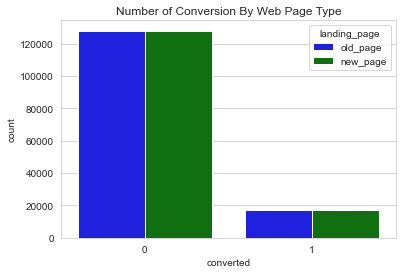

In [15]:
ax=sns.countplot(x="converted", data=data, hue="landing_page", palette=['blue','green'])
ax.set(title="Number of Conversion By Web Page Type")

The plot above indicates there no much difference between the number of conversions generated by the old web page and the new web page. We can compute the conversion rates of each group for further exploration.

In [ ]:
# The probability of an individual converting given that an individual was in the control group
len(data.query('group=="control" and converted==1'))/len(data.query('group=="control"'))

0.1203863045004612

In [ ]:
# The probability of an individual converting given that an individual was in the treatment group
len(data.query('group=="treatment" and converted==1'))/len(data.query('group=="treatment"'))

0.11880724790277405

The users from the ***control*** group had a conversion rate of ***12.03%*** and the users from the ***treatment*** group had a conversion rate of ***11.88%***. We notice the users of the old web page have a bit higher conversion rate than the users of the new web page.  
It seems the new web page is not doing a better job compared to the old web page. To reach a firm conclusion we will conduct a Chi-square test for independence.

# Chi-Square Test For Independence

***

## Define The Test Hypotheses 

To begin our test, we first define our ***Null hypothesis*** and the ***Alternate hypothesis***. We also define our alpha value which will later be used in interpretating the result of our test.

In [ ]:
# Define the hypotheses & acceptance criteria for test
null_hypothesis = "There is no relationship between landing page type and conversion rate."
alternate_hypothesis = "There is a relationship between landing page type and conversion rate."
alpha = 0.05

In [ ]:
# Summarises our dataset to a 2x2 matrix for landing_page by conversion
matrix = pd.crosstab(data.landing_page, data.converted).values

# run the chi-square test
chi2_statistic, p_value, dof, expected_values = chi2_contingency(matrix)

# print chi-square statistic
chi2_statistic

1.7053502645115002

In [ ]:
# print p-value
p_value

0.19158976298516003

In [ ]:
# find the critical value for our test
critical_value = chi2.ppf(1 - alpha, dof)

# print critical value
critical_value

3.841458820694124

# Analyses of Results & Conclusion

***

The results obtained from the Chi-Square test above give us a p-value of ***0.19*** which is greater than our alpha value of ***0.05*** and a chi-square statistic of ***1.71*** which is less than our critical value of ***3.84***.  
Hence we fail to reject the Null Hypothesis and conclude that there is no significant difference between the conversion rates of the old landing page and the new landing page.  

In conclusion, the result of our analysis shows that it will not be a good idea for the company to change their old web page for this new one at the moment.  
I recommend that the company runs the experiment again to collect more data and make sure users from each group only access the web page their supposed to access. This will help to avoid a mismatched data situation and obtain more insight.